# Intervention Notebook

This notebook demonstrates activation patching and intervention experiments to test reasoning direction influence on model outputs.

In [1]:
import sys
sys.path.append('../pipeline')

import os


# Set HuggingFace cache directory to scratch to avoid home directory out of memory
os.environ['HF_HOME'] = '/scratch/gilbreth/sramishe'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/gilbreth/sramishe/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/gilbreth/sramishe/datasets'
 
import torch
import numpy as np
import matplotlib.pyplot as plt

from model_loader import ModelLoader
from data_processor import DataProcessor
from direction_calculator import DirectionCalculator
from intervention import ActivationPatcher

print(f"HuggingFace cache directory set to: {os.environ['HF_HOME']}")

/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


HuggingFace cache directory set to: /scratch/gilbreth/sramishe


## Setup: Load Models, Data, and Directions

In [2]:
# Load models
loader = ModelLoader()
models = loader.load_models(torch_dtype=torch.float16)

rl_model = models['rl_model']
rl_tokenizer = models['rl_tokenizer']

Loading RL-trained model: Qwen/QwQ-32B-Preview


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 17/17 [01:01<00:00,  3.64s/it]


Loading distilled model: deepseek-ai/DeepSeek-R1-Distill-Qwen-32B


Loading checkpoint shards: 100%|██████████| 8/8 [10:24<00:00, 78.07s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [10]:
# Load or compute directions
calculator = DirectionCalculator()

# Option 1: Load pre-computed directions
try:
    calculator.load_directions('/scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt')
    print("Loaded pre-computed directions")
except:
    print("No pre-computed directions found. Please run direction_calculator.ipynb first.")
    # Or compute them here...

directions = calculator.directions

Directions loaded from /scratch/gilbreth/sramishe/results_QwQ_R1/results/reasoning_directions.pt
Loaded pre-computed directions


In [11]:
# Prepare test prompts
processor = DataProcessor()
toy_tasks = processor.get_toy_tasks()

test_prompt = processor.format_prompt("What is 2+2?", rl_tokenizer)
print("Test prompt:")
print(test_prompt)

Test prompt:
<|im_start|>system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.<|im_end|>
<|im_start|>user
What is 2+2?<|im_end|>
<|im_start|>assistant



## Initialize Activation Patcher

In [12]:
patcher = ActivationPatcher(rl_model, directions)

## Baseline Generation (No Intervention)

In [13]:
inputs = rl_tokenizer(test_prompt, return_tensors="pt").to(rl_model.device)

with torch.no_grad():
    baseline_output = rl_model.generate(**inputs, max_new_tokens=256)

baseline_text = rl_tokenizer.decode(baseline_output[0], skip_special_tokens=True)

print("Baseline Output:")
print(baseline_text)
print(f"\nToken count: {len(baseline_output[0])}")

Baseline Output:
system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.
user
What is 2+2?
assistant
2 plus 2? That's a pretty straightforward question. I learned this in the first grade, right? So, 2 plus 2 equals 4. But maybe you're asking something more complicated, like 2 plus 2 in different number systems or something like that. Wait, no, probably not. You just asked "What is 2+2?" So, it's just basic arithmetic.

Let me think about this step by step. Addition is combining two quantities together to find the total. So, if I have two apples and I add two more apples, how many apples do I have? Four apples. So, 2 plus 2 equals 4.

But to be thorough, maybe I should consider other possibilities. Is there any context where 2 plus 2 might not equal 4? Like in modular arithmetic, for example. In modulo 3, 2 plus 2 equals 1, because 2 plus 2 is 4, and 4 modulo 3 is 1. But that seems unlikely, since you didn't specify any modulus.

## Single Layer Intervention

In [14]:
# Test intervention on a single layer
test_layer = list(directions.keys())[0]
test_strength = 0.1

intervened_output = patcher.generate_with_intervention(
    tokenizer=rl_tokenizer,
    prompt=test_prompt,
    layers=[test_layer],
    strength=test_strength,
    max_new_tokens=256
)

print(f"Intervened Output (Layer {test_layer}, Strength {test_strength}):")
print(intervened_output)
print(f"\nToken count: {len(rl_tokenizer.encode(intervened_output))}")

Applied interventions to layers: [0]
Intervened Output (Layer 0, Strength 0.1):
system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.
user
What is 2+2?
assistant
2 plus 2... that's a pretty straightforward question. I learned this in the first grade, right? So, 2 plus 2 equals 4. But let's think about it step by step to make sure.

First, what does "plus" mean? Plus means addition, which is combining two quantities together to find the total. So, if I have 2 apples and I get 2 more apples, how many apples do I have in total?

Let me visualize this. Imagine I have two apples on the table. Then, someone gives me two more apples. Now, I need to count all the apples together.

One apple, two apples, three apples, four apples. So, 2 plus 2 equals 4.

Alternatively, I can use my fingers. Hold up two fingers on one hand and two fingers on the other hand, then count all the fingers together: 1, 2, 3, 4.

Another way is to think about

## Compare Baseline vs Intervened

In [15]:
print("BASELINE:")
print("="*60)
print(baseline_text)
print("\n" + "="*60)

print("\nINTERVENED:")
print("="*60)
print(intervened_output)
print("="*60)

BASELINE:
system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.
user
What is 2+2?
assistant
2 plus 2? That's a pretty straightforward question. I learned this in the first grade, right? So, 2 plus 2 equals 4. But maybe you're asking something more complicated, like 2 plus 2 in different number systems or something like that. Wait, no, probably not. You just asked "What is 2+2?" So, it's just basic arithmetic.

Let me think about this step by step. Addition is combining two quantities together to find the total. So, if I have two apples and I add two more apples, how many apples do I have? Four apples. So, 2 plus 2 equals 4.

But to be thorough, maybe I should consider other possibilities. Is there any context where 2 plus 2 might not equal 4? Like in modular arithmetic, for example. In modulo 3, 2 plus 2 equals 1, because 2 plus 2 is 4, and 4 modulo 3 is 1. But that seems unlikely, since you didn't specify any modulus.

Alter

## Sweep Across Multiple Layers

In [16]:
# Test multiple layers with same strength
layers_to_test = sorted(directions.keys())[:5]  # Test first 5 layers
strength = 0.1

layer_results = {}

for layer in layers_to_test:
    output = patcher.generate_with_intervention(
        tokenizer=rl_tokenizer,
        prompt=test_prompt,
        layers=[layer],
        strength=strength,
        max_new_tokens=256
    )
    layer_results[layer] = {
        'output': output,
        'token_count': len(rl_tokenizer.encode(output))
    }
    print(f"Completed layer {layer}")

Applied interventions to layers: [0]
Completed layer 0
Applied interventions to layers: [5]
Completed layer 5
Applied interventions to layers: [10]
Completed layer 10
Applied interventions to layers: [15]
Completed layer 15
Applied interventions to layers: [20]
Completed layer 20


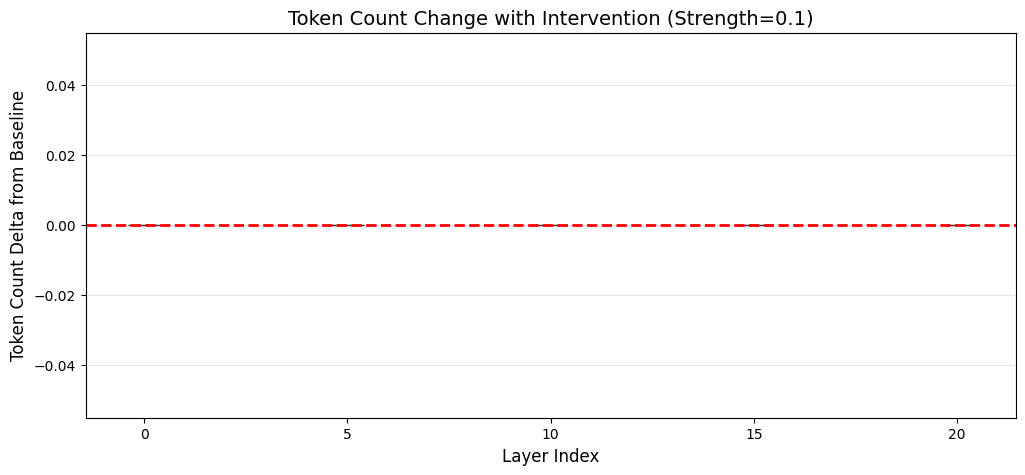

In [17]:
# Visualize token count changes
baseline_tokens = len(rl_tokenizer.encode(baseline_text))
layer_indices = list(layer_results.keys())
token_counts = [layer_results[layer]['token_count'] for layer in layer_indices]
token_deltas = [count - baseline_tokens for count in token_counts]

plt.figure(figsize=(12, 5))
plt.bar(layer_indices, token_deltas, color='steelblue', edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Layer Index', fontsize=12)
plt.ylabel('Token Count Delta from Baseline', fontsize=12)
plt.title(f'Token Count Change with Intervention (Strength={strength})', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

## Sweep Across Multiple Strengths

In [18]:
# Test single layer with multiple strengths
test_layer = list(directions.keys())[0]
strengths = np.linspace(-0.1, 0.1, 5)

strength_results = {}

for strength in strengths:
    output = patcher.generate_with_intervention(
        tokenizer=rl_tokenizer,
        prompt=test_prompt,
        layers=[test_layer],
        strength=float(strength),
        max_new_tokens=256
    )
    strength_results[float(strength)] = {
        'output': output,
        'token_count': len(rl_tokenizer.encode(output))
    }
    print(f"Completed strength {strength:.3f}")

Applied interventions to layers: [0]
Completed strength -0.100
Applied interventions to layers: [0]
Completed strength -0.050
Applied interventions to layers: [0]
Completed strength 0.000
Applied interventions to layers: [0]
Completed strength 0.050
Applied interventions to layers: [0]
Completed strength 0.100


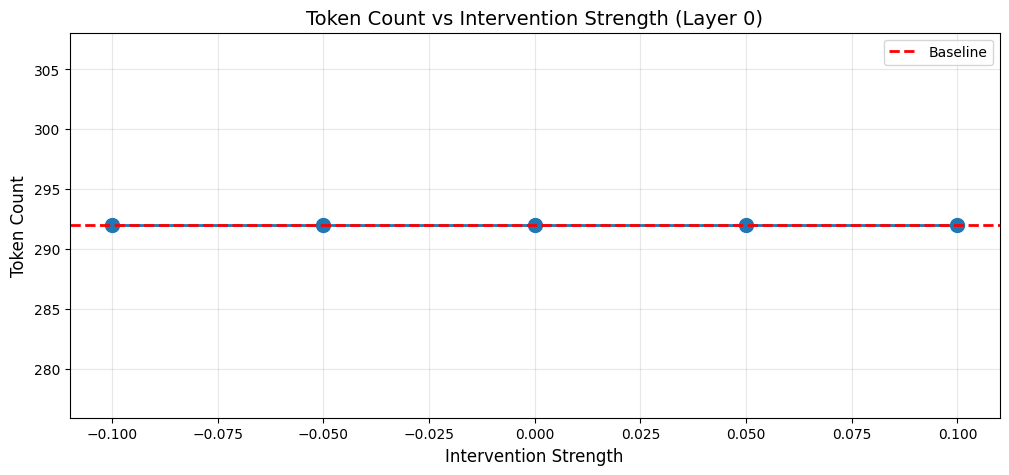

In [19]:
# Visualize strength effects
strength_values = sorted(strength_results.keys())
token_counts = [strength_results[s]['token_count'] for s in strength_values]

plt.figure(figsize=(12, 5))
plt.plot(strength_values, token_counts, marker='o', linewidth=2, markersize=10)
plt.axhline(y=baseline_tokens, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.xlabel('Intervention Strength', fontsize=12)
plt.ylabel('Token Count', fontsize=12)
plt.title(f'Token Count vs Intervention Strength (Layer {test_layer})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Full Parameter Sweep

In [20]:
# Sweep both layers and strengths
layer_range = (0, min(10, max(directions.keys())))  # First 10 layers
strength_range = (-0.1, 0.1)
num_strengths = 5

sweep_results = patcher.sweep_layers_and_strengths(
    tokenizer=rl_tokenizer,
    prompt=test_prompt,
    layer_range=layer_range,
    strength_range=strength_range,
    num_strengths=num_strengths,
    max_new_tokens=256
)

print(f"Completed {len(sweep_results)} experiments")

Applied interventions to layers: [0]
Applied interventions to layers: [0]
Applied interventions to layers: [0]
Applied interventions to layers: [0]
Applied interventions to layers: [0]
Applied interventions to layers: [5]
Applied interventions to layers: [5]
Applied interventions to layers: [5]
Applied interventions to layers: [5]
Applied interventions to layers: [5]
Applied interventions to layers: [10]
Applied interventions to layers: [10]
Applied interventions to layers: [10]
Applied interventions to layers: [10]
Applied interventions to layers: [10]
Completed 15 experiments


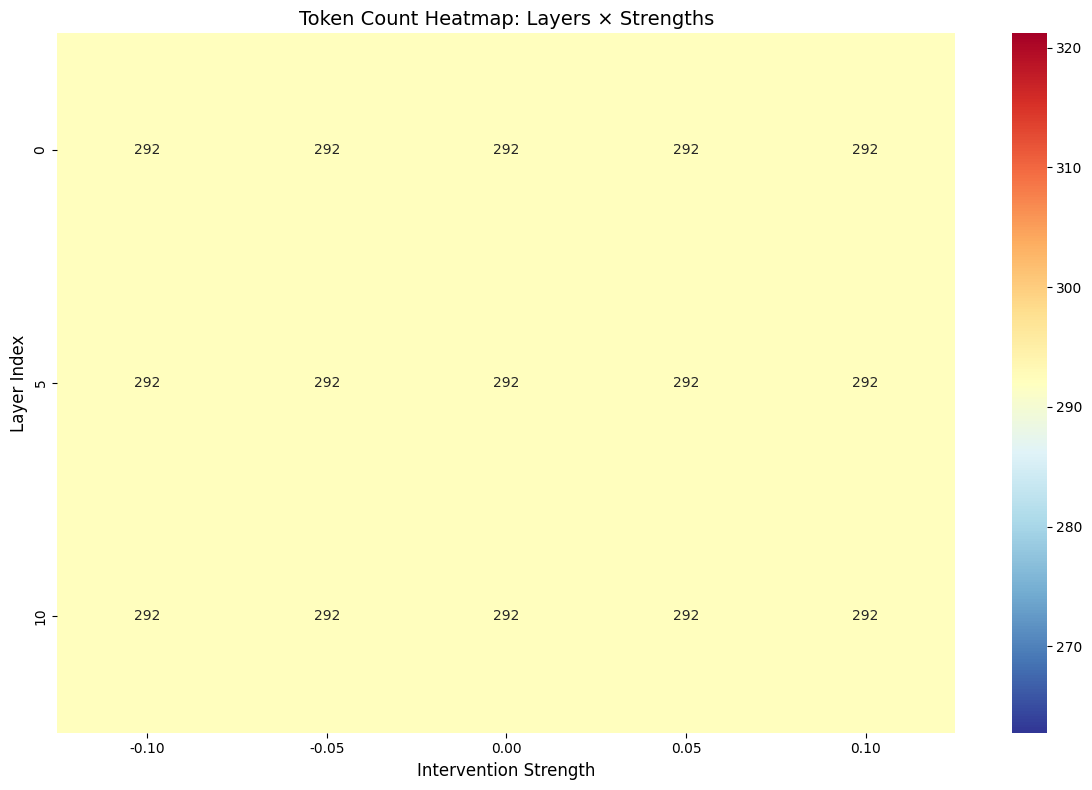

In [21]:
# Create heatmap of results
from collections import defaultdict

# Organize results into matrix
layer_strength_map = defaultdict(dict)
for result in sweep_results:
    layer = result['layer']
    strength = result['strength']
    token_count = result['token_count']
    layer_strength_map[layer][strength] = token_count

# Convert to matrix
layers = sorted(layer_strength_map.keys())
strengths = sorted(list(layer_strength_map[layers[0]].keys()))
matrix = np.array([[layer_strength_map[l].get(s, 0) for s in strengths] for l in layers])

# Plot heatmap
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(matrix, 
            xticklabels=[f"{s:.2f}" for s in strengths],
            yticklabels=layers,
            cmap='RdYlBu_r',
            annot=True,
            fmt='d')
plt.xlabel('Intervention Strength', fontsize=12)
plt.ylabel('Layer Index', fontsize=12)
plt.title('Token Count Heatmap: Layers × Strengths', fontsize=14)
plt.tight_layout()
plt.show()

## Inspect Specific Outputs

In [22]:
# Find most extreme intervention
max_result = max(sweep_results, key=lambda x: x['token_count'])
min_result = min(sweep_results, key=lambda x: x['token_count'])

print("MAXIMUM TOKEN COUNT INTERVENTION:")
print(f"Layer: {max_result['layer']}, Strength: {max_result['strength']:.3f}")
print(f"Token count: {max_result['token_count']}")
print("Output:")
print(max_result['output'])

print("\n" + "="*60 + "\n")

print("MINIMUM TOKEN COUNT INTERVENTION:")
print(f"Layer: {min_result['layer']}, Strength: {min_result['strength']:.3f}")
print(f"Token count: {min_result['token_count']}")
print("Output:")
print(min_result['output'])

MAXIMUM TOKEN COUNT INTERVENTION:
Layer: 0, Strength: -0.100
Token count: 292
Output:
system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.
user
What is 2+2?
assistant
2 plus 2... that's a pretty straightforward question. I learned this in the first grade, right? So, 2 plus 2 equals 4. But let's think about it step by step to make sure.

First, what does "plus" mean? Plus means addition, which is combining two quantities together to find the total. So, if I have 2 apples and I get 2 more apples, how many apples do I have in total?

Let me visualize this. Imagine I have two apples on the table. Then, someone gives me two more apples. Now, I need to count all the apples together.

One apple, two apples, three apples, four apples. So, 2 plus 2 equals 4.

Alternatively, I can use my fingers. Hold up two fingers on one hand and two fingers on the other hand, then count all the fingers together: 1, 2, 3, 4.

Another way is to think